This notebook implements the Baseline 1 approach, for plant species classification, using the EfficientNetB3 architecture.

# 1.0 Environment Setup

## 1.1 Import Libraries

In [1]:
import random, os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## 1.2 Check GPU Availability

In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# 2.0 Data Loading and Preparation

## 2.1 Load Metadata

In [3]:
# paths to metadata files
train_file = "list/train.txt"
test_file = "list/test.txt"
groundtruth_file = "list/groundtruth.txt"
species_list_file = "list/species_list.txt"
class_with_pairs_file = "list/class_with_pairs.txt"
class_without_pairs_file = "list/class_without_pairs.txt"

# Load species name mapping
species_df = pd.read_csv(species_list_file, sep=";", header=None, names=["class_id", "name"])
species_df["class_id"] = species_df["class_id"].astype(str)

## 2.2 Load Class Groups and Groundtruth

In [4]:
# Load class groups
with open(class_with_pairs_file) as f:
    class_with_pairs = [line.strip() for line in f if line.strip()]
with open(class_without_pairs_file) as f:
    class_without_pairs = [line.strip() for line in f if line.strip()]

print(f"Classes with pairs: {len(class_with_pairs)} | Classes without pairs: {len(class_without_pairs)}")

# Load groundtruth for test
gt_pairs = []
with open(groundtruth_file) as f:
    for line in f:
        path, cid = line.strip().split()
        gt_pairs.append((path, cid))
groundtruth = pd.DataFrame(gt_pairs, columns=["path", "class_id"])
groundtruth["class_id"] = groundtruth["class_id"].astype(str)

# Load train list
train_list = []
with open(train_file) as f:
    for line in f:
        path, cid = line.strip().split()
        train_list.append((path, cid))
train_df = pd.DataFrame(train_list, columns=["path", "class_id"])
train_df["class_id"] = train_df["class_id"].astype(str)

# Create class index mapping
unique_classes = sorted(train_df["class_id"].unique())
class_to_idx = {cid: idx for idx, cid in enumerate(unique_classes)}
idx_to_class = {v: k for k, v in class_to_idx.items()}
num_classes = len(unique_classes)

print(f"Number of classes in training: {num_classes}")

Classes with pairs: 60 | Classes without pairs: 40
Number of classes in training: 100


## 2.3 Create Training and Validation Sets

In [5]:
# Split train into train and validation sets

train_df_final, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"Training samples: {len(train_df_final)} | Validation samples: {len(val_df)}")

Training samples: 3795 | Validation samples: 949


## 2.4 Visualise Sample Images

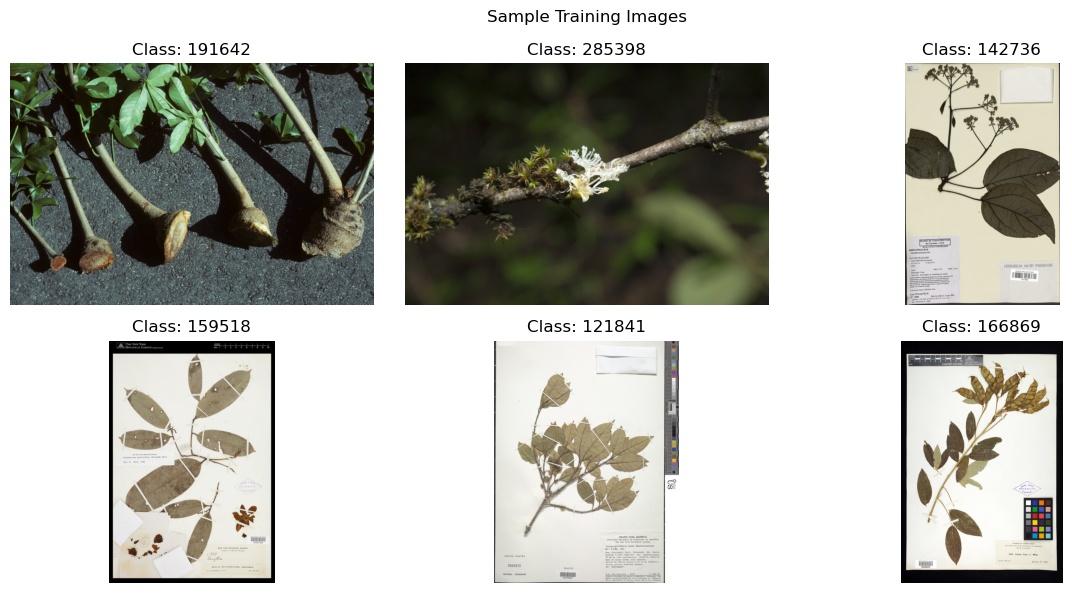

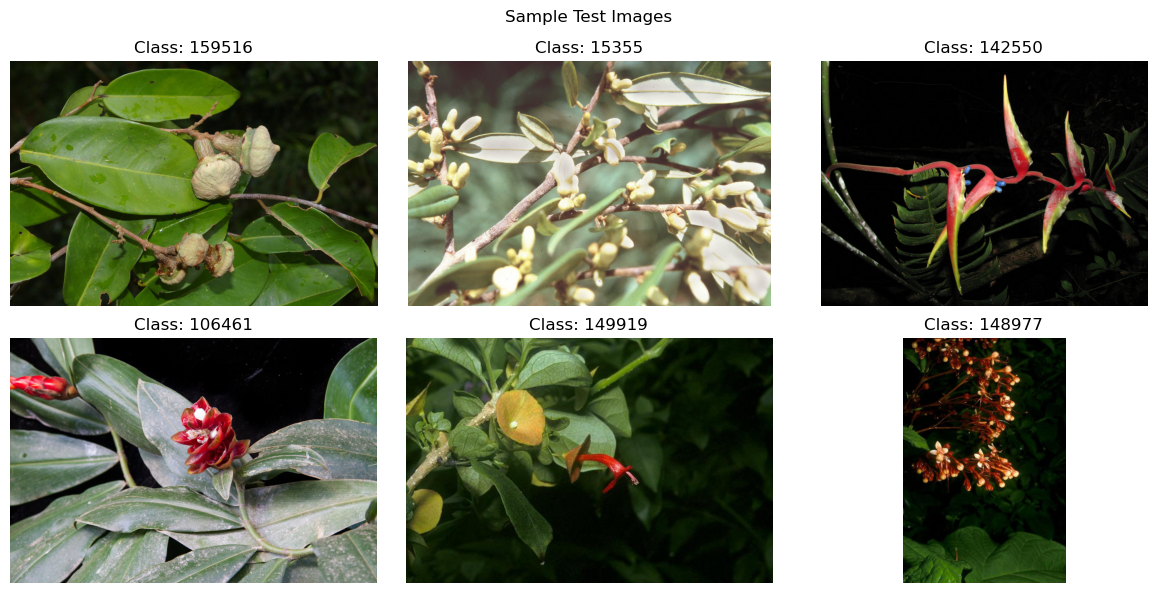

In [6]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Function to show a few sample images
def show_samples(file_list, title, num_samples=6):
    samples = random.sample(file_list, min(num_samples, len(file_list)))
    plt.figure(figsize=(12, 6))
    for i, (img_path, label) in enumerate(samples):
        try:
            img = Image.open(img_path).convert("RGB")
            plt.subplot(2, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {label}")
            plt.axis("off")
        except Exception as e:
            print(f"Could not load image {img_path}: {e}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Prepare lists from your train and test text files
train_list = []
with open(train_file) as f:
    for line in f:
        path, label = line.strip().split()
        train_list.append((path, label))

test_list = []
with open(test_file) as f:
    for line in f:
        path = line.strip()
        # try to get the class from groundtruth if available
        test_label = None
        with open(groundtruth_file) as gt:
            for gt_line in gt:
                if gt_line.startswith(path):
                    test_label = gt_line.strip().split()[1]
                    break
        test_list.append((path, test_label))

# Show a few images
show_samples(train_list, "Sample Training Images", num_samples=6)
show_samples(test_list, "Sample Test Images", num_samples=6)


# 3.0 Dataset Class and Preprocessing

## 3.1 Define Train Image Dataset

In [7]:
class PlantDataset(Dataset):
    def __init__(self, df, class_to_idx, transform=None, root="."):
        self.df = df.reset_index(drop=True)
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.root = root

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "path"]
        label_id = self.df.loc[idx, "class_id"]
        img_full = os.path.join(self.root, img_path)
        image = Image.open(img_full).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.class_to_idx[label_id]
        return image, label

## 3.2 Data Augmentation and Transformation

In [8]:
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(300, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_tfms = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

## 3.3 Set Up Dataset Loader

In [9]:
# --- Create datasets ---
train_ds = PlantDataset(train_df_final, class_to_idx, transform=train_tfms)
val_ds   = PlantDataset(val_df, class_to_idx, transform=test_tfms)  # use test_tfms (no aug)
test_ds  = PlantDataset(
    groundtruth[groundtruth["class_id"].isin(unique_classes)],
    class_to_idx,
    transform=test_tfms
)

# --- Dataloaders ---
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f"Train batches: {len(train_dl)}, Val batches: {len(val_dl)}, Test batches: {len(test_dl)}")

Train batches: 119, Val batches: 30, Test batches: 7


# 4.0 Model Setup

## 4.1 Model Architecture and Fine-tuning Setup

In [ ]:
model = models.efficientnet_b3(pretrained=True)

# Unfreeze the last few blocks for adaptation
for name, param in model.named_parameters():
    if "features.5" in name or "features.6" in name or "features.7" in name:  # last two blocks
        param.requires_grad = True
    else:
        param.requires_grad = False

# Replace classifier
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)
model = model.to(device)

# Use smaller LR for pretrained layers
optimizer = optim.AdamW([
    {'params': model.features.parameters(), 'lr': 5e-5},
    {'params': model.classifier.parameters(), 'lr': 1e-4}
], weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

C:\Users\Asus TUF\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Asus TUF\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 4.2 Training loop

In [11]:
EPOCHS = 60  # baseline quick run
best_val_loss = float("inf")
patience = 4
patience_cnt = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # ---- Training loop ----
    loop = tqdm(train_dl, desc=f"Train Epoch {epoch+1}/{EPOCHS}")
    for imgs, labels, in loop:
        imgs = imgs.to(device)
        labels = labels.to(device)
        # some dataset entries may have label == -1 (shouldn't in train), skip them
        mask = (labels >= 0)
        if mask.sum().item() == 0: 
            continue
        imgs = imgs[mask]
        labels = labels[mask]

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / max(1, len(train_dl))
    train_acc = correct / max(1, total)

    # ---- Validation loop ----
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels, in tqdm(val_dl, desc=f"Val Epoch {epoch+1}/{EPOCHS}"):
            imgs = imgs.to(device)
            labels = labels.to(device)
            mask = (labels >= 0)
            if mask.sum().item() == 0: 
                continue
            imgs = imgs[mask]
            labels = labels[mask]

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / max(1, len(val_dl))
    val_acc = val_correct / max(1, val_total)

    train_losses.append(train_loss); val_losses.append(val_loss)
    train_accs.append(train_acc); val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    # scheduler step
    try:
        scheduler.step()
    except:
        pass

    # checkpointing
    if val_loss < best_val_loss - 1e-5:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'class_to_idx': class_to_idx,
            'idx_to_class': idx_to_class
        }, "best_efficientnetb3_finetuned3.pth")
        print(f"Saved best model at epoch {epoch+1} (val_loss={val_loss:.4f})")
        patience_cnt = 0
    else:
        patience_cnt += 1
        if patience_cnt >= patience:
            print("Early stopping triggered.")
            break

Val Epoch 1/60: 100%|██████████| 30/30 [00:23<00:00,  1.28it/s]


Epoch [1/60] Train Loss: 4.5845, Val Loss: 4.5401, Train Acc: 0.0213, Val Acc: 0.0632
Saved best model at epoch 1 (val_loss=4.5401)


Val Epoch 2/60: 100%|██████████| 30/30 [00:14<00:00,  2.13it/s]


Epoch [2/60] Train Loss: 4.4319, Val Loss: 4.2463, Train Acc: 0.0798, Val Acc: 0.1401
Saved best model at epoch 2 (val_loss=4.2463)


Val Epoch 3/60: 100%|██████████| 30/30 [00:14<00:00,  2.13it/s]


Epoch [3/60] Train Loss: 4.0190, Val Loss: 3.7593, Train Acc: 0.1592, Val Acc: 0.2403
Saved best model at epoch 3 (val_loss=3.7593)


Val Epoch 4/60: 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Epoch [4/60] Train Loss: 3.5888, Val Loss: 3.4190, Train Acc: 0.2406, Val Acc: 0.3109
Saved best model at epoch 4 (val_loss=3.4190)


Val Epoch 5/60: 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Epoch [5/60] Train Loss: 3.3322, Val Loss: 3.2199, Train Acc: 0.2819, Val Acc: 0.3583
Saved best model at epoch 5 (val_loss=3.2199)


Val Epoch 6/60: 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


Epoch [6/60] Train Loss: 3.1224, Val Loss: 3.0773, Train Acc: 0.3352, Val Acc: 0.3730
Saved best model at epoch 6 (val_loss=3.0773)


Val Epoch 7/60: 100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


Epoch [7/60] Train Loss: 3.0054, Val Loss: 3.0109, Train Acc: 0.3623, Val Acc: 0.3846
Saved best model at epoch 7 (val_loss=3.0109)


Val Epoch 8/60: 100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


Epoch [8/60] Train Loss: 2.9200, Val Loss: 2.9560, Train Acc: 0.3855, Val Acc: 0.4110
Saved best model at epoch 8 (val_loss=2.9560)


Val Epoch 9/60: 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Epoch [9/60] Train Loss: 2.8743, Val Loss: 2.9314, Train Acc: 0.4000, Val Acc: 0.4120
Saved best model at epoch 9 (val_loss=2.9314)


Val Epoch 10/60: 100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


Epoch [10/60] Train Loss: 2.8715, Val Loss: 2.9410, Train Acc: 0.4103, Val Acc: 0.4183


Val Epoch 11/60: 100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


Epoch [11/60] Train Loss: 2.8698, Val Loss: 2.9304, Train Acc: 0.4095, Val Acc: 0.4162
Saved best model at epoch 11 (val_loss=2.9304)


Val Epoch 12/60: 100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


Epoch [12/60] Train Loss: 2.8494, Val Loss: 2.9336, Train Acc: 0.4087, Val Acc: 0.4110


Val Epoch 13/60: 100%|██████████| 30/30 [00:14<00:00,  2.14it/s]


Epoch [13/60] Train Loss: 2.8331, Val Loss: 2.9104, Train Acc: 0.4166, Val Acc: 0.4194
Saved best model at epoch 13 (val_loss=2.9104)


Val Epoch 14/60: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Epoch [14/60] Train Loss: 2.8284, Val Loss: 2.8747, Train Acc: 0.4140, Val Acc: 0.4310
Saved best model at epoch 14 (val_loss=2.8747)


Val Epoch 15/60: 100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


Epoch [15/60] Train Loss: 2.7717, Val Loss: 2.8147, Train Acc: 0.4271, Val Acc: 0.4468
Saved best model at epoch 15 (val_loss=2.8147)


Val Epoch 16/60: 100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


Epoch [16/60] Train Loss: 2.7039, Val Loss: 2.7570, Train Acc: 0.4472, Val Acc: 0.4573
Saved best model at epoch 16 (val_loss=2.7570)


Val Epoch 17/60: 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Epoch [17/60] Train Loss: 2.6194, Val Loss: 2.6551, Train Acc: 0.4740, Val Acc: 0.4742
Saved best model at epoch 17 (val_loss=2.6551)


Val Epoch 18/60: 100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


Epoch [18/60] Train Loss: 2.5181, Val Loss: 2.5638, Train Acc: 0.4891, Val Acc: 0.5068
Saved best model at epoch 18 (val_loss=2.5638)


Val Epoch 19/60: 100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


Epoch [19/60] Train Loss: 2.4048, Val Loss: 2.4771, Train Acc: 0.5265, Val Acc: 0.5342
Saved best model at epoch 19 (val_loss=2.4771)


Val Epoch 20/60: 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Epoch [20/60] Train Loss: 2.2970, Val Loss: 2.4217, Train Acc: 0.5697, Val Acc: 0.5385
Saved best model at epoch 20 (val_loss=2.4217)


Val Epoch 21/60: 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


Epoch [21/60] Train Loss: 2.1704, Val Loss: 2.3512, Train Acc: 0.6042, Val Acc: 0.5659
Saved best model at epoch 21 (val_loss=2.3512)


Val Epoch 22/60: 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


Epoch [22/60] Train Loss: 2.0450, Val Loss: 2.2958, Train Acc: 0.6422, Val Acc: 0.5722
Saved best model at epoch 22 (val_loss=2.2958)


Val Epoch 23/60: 100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


Epoch [23/60] Train Loss: 1.9791, Val Loss: 2.2485, Train Acc: 0.6567, Val Acc: 0.5817
Saved best model at epoch 23 (val_loss=2.2485)


Val Epoch 24/60: 100%|██████████| 30/30 [00:23<00:00,  1.27it/s]


Epoch [24/60] Train Loss: 1.8809, Val Loss: 2.2043, Train Acc: 0.6933, Val Acc: 0.5880
Saved best model at epoch 24 (val_loss=2.2043)


Val Epoch 25/60: 100%|██████████| 30/30 [00:14<00:00,  2.04it/s]


Epoch [25/60] Train Loss: 1.8235, Val Loss: 2.1785, Train Acc: 0.7101, Val Acc: 0.6048
Saved best model at epoch 25 (val_loss=2.1785)


Val Epoch 26/60: 100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


Epoch [26/60] Train Loss: 1.7681, Val Loss: 2.1599, Train Acc: 0.7273, Val Acc: 0.6112
Saved best model at epoch 26 (val_loss=2.1599)


Val Epoch 27/60: 100%|██████████| 30/30 [00:14<00:00,  2.08it/s]


Epoch [27/60] Train Loss: 1.7330, Val Loss: 2.1490, Train Acc: 0.7415, Val Acc: 0.6122
Saved best model at epoch 27 (val_loss=2.1490)


Val Epoch 28/60: 100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


Epoch [28/60] Train Loss: 1.6964, Val Loss: 2.1379, Train Acc: 0.7544, Val Acc: 0.6196
Saved best model at epoch 28 (val_loss=2.1379)


Val Epoch 29/60: 100%|██████████| 30/30 [00:14<00:00,  2.14it/s]


Epoch [29/60] Train Loss: 1.6782, Val Loss: 2.1315, Train Acc: 0.7652, Val Acc: 0.6164
Saved best model at epoch 29 (val_loss=2.1315)


Val Epoch 30/60: 100%|██████████| 30/30 [00:14<00:00,  2.10it/s]


Epoch [30/60] Train Loss: 1.6958, Val Loss: 2.1310, Train Acc: 0.7513, Val Acc: 0.6080
Saved best model at epoch 30 (val_loss=2.1310)


Val Epoch 31/60: 100%|██████████| 30/30 [00:14<00:00,  2.12it/s]


Epoch [31/60] Train Loss: 1.6662, Val Loss: 2.1287, Train Acc: 0.7686, Val Acc: 0.6112
Saved best model at epoch 31 (val_loss=2.1287)


Val Epoch 32/60: 100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


Epoch [32/60] Train Loss: 1.6606, Val Loss: 2.1358, Train Acc: 0.7618, Val Acc: 0.6143


Val Epoch 33/60: 100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


Epoch [33/60] Train Loss: 1.6722, Val Loss: 2.1275, Train Acc: 0.7655, Val Acc: 0.6175
Saved best model at epoch 33 (val_loss=2.1275)


Val Epoch 34/60: 100%|██████████| 30/30 [00:14<00:00,  2.11it/s]


Epoch [34/60] Train Loss: 1.6698, Val Loss: 2.1194, Train Acc: 0.7610, Val Acc: 0.6196
Saved best model at epoch 34 (val_loss=2.1194)


Val Epoch 35/60: 100%|██████████| 30/30 [00:14<00:00,  2.08it/s]


Epoch [35/60] Train Loss: 1.6585, Val Loss: 2.1203, Train Acc: 0.7676, Val Acc: 0.6059


Val Epoch 36/60: 100%|██████████| 30/30 [00:14<00:00,  2.06it/s]


Epoch [36/60] Train Loss: 1.6478, Val Loss: 2.1005, Train Acc: 0.7684, Val Acc: 0.6270
Saved best model at epoch 36 (val_loss=2.1005)


Val Epoch 37/60: 100%|██████████| 30/30 [00:14<00:00,  2.08it/s]


Epoch [37/60] Train Loss: 1.5940, Val Loss: 2.0983, Train Acc: 0.7953, Val Acc: 0.6133
Saved best model at epoch 37 (val_loss=2.0983)


Val Epoch 38/60: 100%|██████████| 30/30 [00:14<00:00,  2.10it/s]


Epoch [38/60] Train Loss: 1.5674, Val Loss: 2.0818, Train Acc: 0.7968, Val Acc: 0.6196
Saved best model at epoch 38 (val_loss=2.0818)


Val Epoch 39/60: 100%|██████████| 30/30 [00:14<00:00,  2.13it/s]


Epoch [39/60] Train Loss: 1.5326, Val Loss: 2.0708, Train Acc: 0.8097, Val Acc: 0.6333
Saved best model at epoch 39 (val_loss=2.0708)


Val Epoch 40/60: 100%|██████████| 30/30 [00:14<00:00,  2.03it/s]


Epoch [40/60] Train Loss: 1.4882, Val Loss: 2.0711, Train Acc: 0.8303, Val Acc: 0.6238


Val Epoch 41/60: 100%|██████████| 30/30 [00:14<00:00,  2.12it/s]


Epoch [41/60] Train Loss: 1.4592, Val Loss: 2.0623, Train Acc: 0.8358, Val Acc: 0.6249
Saved best model at epoch 41 (val_loss=2.0623)


Val Epoch 42/60: 100%|██████████| 30/30 [00:14<00:00,  2.11it/s]


Epoch [42/60] Train Loss: 1.4206, Val Loss: 2.0421, Train Acc: 0.8490, Val Acc: 0.6312
Saved best model at epoch 42 (val_loss=2.0421)


Val Epoch 43/60: 100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


Epoch [43/60] Train Loss: 1.3824, Val Loss: 2.0358, Train Acc: 0.8667, Val Acc: 0.6449
Saved best model at epoch 43 (val_loss=2.0358)


Val Epoch 44/60: 100%|██████████| 30/30 [00:14<00:00,  2.14it/s]


Epoch [44/60] Train Loss: 1.3539, Val Loss: 2.0378, Train Acc: 0.8764, Val Acc: 0.6333


Val Epoch 45/60: 100%|██████████| 30/30 [00:14<00:00,  2.14it/s]


Epoch [45/60] Train Loss: 1.3181, Val Loss: 2.0274, Train Acc: 0.8814, Val Acc: 0.6333
Saved best model at epoch 45 (val_loss=2.0274)


Val Epoch 46/60: 100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


Epoch [46/60] Train Loss: 1.2887, Val Loss: 2.0256, Train Acc: 0.8954, Val Acc: 0.6354
Saved best model at epoch 46 (val_loss=2.0256)


Val Epoch 47/60: 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]


Epoch [47/60] Train Loss: 1.2739, Val Loss: 2.0187, Train Acc: 0.8993, Val Acc: 0.6428
Saved best model at epoch 47 (val_loss=2.0187)


Val Epoch 48/60: 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]


Epoch [48/60] Train Loss: 1.2668, Val Loss: 2.0198, Train Acc: 0.9078, Val Acc: 0.6417


Val Epoch 49/60: 100%|██████████| 30/30 [00:22<00:00,  1.36it/s]


Epoch [49/60] Train Loss: 1.2506, Val Loss: 2.0171, Train Acc: 0.9128, Val Acc: 0.6449
Saved best model at epoch 49 (val_loss=2.0171)


Val Epoch 50/60: 100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


Epoch [50/60] Train Loss: 1.2541, Val Loss: 2.0129, Train Acc: 0.9112, Val Acc: 0.6502
Saved best model at epoch 50 (val_loss=2.0129)


Val Epoch 51/60: 100%|██████████| 30/30 [00:17<00:00,  1.73it/s]


Epoch [51/60] Train Loss: 1.2518, Val Loss: 2.0153, Train Acc: 0.9099, Val Acc: 0.6386


Val Epoch 52/60: 100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


Epoch [52/60] Train Loss: 1.2369, Val Loss: 2.0119, Train Acc: 0.9162, Val Acc: 0.6438
Saved best model at epoch 52 (val_loss=2.0119)


Val Epoch 53/60: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Epoch [53/60] Train Loss: 1.2528, Val Loss: 2.0089, Train Acc: 0.9080, Val Acc: 0.6438
Saved best model at epoch 53 (val_loss=2.0089)


Val Epoch 54/60: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Epoch [54/60] Train Loss: 1.2322, Val Loss: 2.0034, Train Acc: 0.9181, Val Acc: 0.6491
Saved best model at epoch 54 (val_loss=2.0034)


Val Epoch 55/60: 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


Epoch [55/60] Train Loss: 1.2355, Val Loss: 2.0049, Train Acc: 0.9175, Val Acc: 0.6491


Val Epoch 56/60: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Epoch [56/60] Train Loss: 1.2315, Val Loss: 2.0164, Train Acc: 0.9165, Val Acc: 0.6428


Val Epoch 57/60: 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


Epoch [57/60] Train Loss: 1.2255, Val Loss: 2.0034, Train Acc: 0.9191, Val Acc: 0.6428


Val Epoch 58/60: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Epoch [58/60] Train Loss: 1.2145, Val Loss: 2.0031, Train Acc: 0.9188, Val Acc: 0.6428
Saved best model at epoch 58 (val_loss=2.0031)


Val Epoch 59/60: 100%|██████████| 30/30 [00:14<00:00,  2.14it/s]


Epoch [59/60] Train Loss: 1.1934, Val Loss: 2.0164, Train Acc: 0.9257, Val Acc: 0.6417


Val Epoch 60/60: 100%|██████████| 30/30 [00:14<00:00,  2.00it/s]

Epoch [60/60] Train Loss: 1.1865, Val Loss: 2.0100, Train Acc: 0.9278, Val Acc: 0.6417


# 5.0 Evaluation

## 5.1 Plot Loss and Train Curve

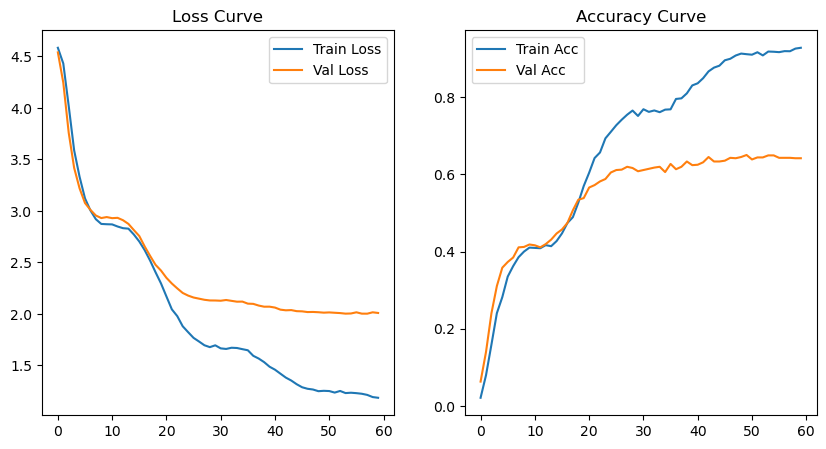

In [12]:
# --- Plot training curve ---
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend(); plt.title("Accuracy Curve")

plt.show()

## 5.2 Evaluate Top-1 and Top-5 

In [13]:
model.eval()
all_labels, all_preds, all_top5 = [], [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_dl, desc="Evaluating"):
        imgs = imgs.to(device)
        outputs = model(imgs)
        top5 = torch.topk(outputs, 5, dim=1).indices.cpu().numpy()
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_labels.extend(labels.numpy())
        all_preds.extend(preds)
        all_top5.extend(top5)

# Map idx -> class_id
labels_class = [idx_to_class[i] for i in all_labels]
preds_class = [idx_to_class[i] for i in all_preds]
top5_classes = [[idx_to_class[j] for j in row] for row in all_top5]

# Evaluate per group
def topk_acc(true_ids, top5_list, k=1):
    correct = 0
    for t, topk in zip(true_ids, top5_list):
        if t in topk[:k]:
            correct += 1
    return correct / len(true_ids)

Evaluating: 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


In [14]:
# Combine into dataframe
res_df = pd.DataFrame({
    "true": labels_class,
    "pred": preds_class,
    "top5": top5_classes
})

# group filters
with_pairs_mask = res_df["true"].isin(class_with_pairs)
without_pairs_mask = res_df["true"].isin(class_without_pairs)

def compute_group_acc(mask, name):
    subset = res_df[mask]
    if len(subset) == 0:
        print(f"No samples for {name}")
        return
    top1 = topk_acc(subset["true"], subset["top5"], k=1)
    top5 = topk_acc(subset["true"], subset["top5"], k=5)
    print(f"{name} - Top1: {top1*100:.2f}%, Top5: {top5*100:.2f}%")

print("=== RESULTS ===")
compute_group_acc(with_pairs_mask, "Classes with pairs")
compute_group_acc(without_pairs_mask, "Classes without pairs")
compute_group_acc(np.ones(len(res_df), dtype=bool), "Overall")

=== RESULTS ===
Classes with pairs - Top1: 72.55%, Top5: 84.97%
Classes without pairs - Top1: 0.00%, Top5: 3.70%
Overall - Top1: 53.62%, Top5: 63.77%


# 6.0 Save Model

In [15]:
save_path = "efficientnetb3_finetuned3_e.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_to_idx': class_to_idx,
    'idx_to_class': idx_to_class,
}, save_path)

print(f"Model saved to {save_path}")


Model saved to efficientnetb3_finetuned3_e.pth
